# NHL In-Game Predictor

Packages and Datasets in Use

In [0]:
dbutils.fs.ls('/FileStore/tables/team_3/nhl/')

Out[1]: [FileInfo(path='dbfs:/FileStore/tables/team_3/nhl/game.csv', name='game.csv', size=1911618),
 FileInfo(path='dbfs:/FileStore/tables/team_3/nhl/game_goalie_stats.csv', name='game_goalie_stats.csv', size=2357517),
 FileInfo(path='dbfs:/FileStore/tables/team_3/nhl/game_plays.csv', name='game_plays.csv', size=592063227),
 FileInfo(path='dbfs:/FileStore/tables/team_3/nhl/game_plays_players.csv', name='game_plays_players.csv', size=286695830),
 FileInfo(path='dbfs:/FileStore/tables/team_3/nhl/game_shifts.csv', name='game_shifts.csv', size=316976976),
 FileInfo(path='dbfs:/FileStore/tables/team_3/nhl/game_skater_stats.csv', name='game_skater_stats.csv', size=30389603),
 FileInfo(path='dbfs:/FileStore/tables/team_3/nhl/game_teams_stats.csv', name='game_teams_stats.csv', size=1741828),
 FileInfo(path='dbfs:/FileStore/tables/team_3/nhl/player_info.csv', name='player_info.csv', size=209552),
 FileInfo(path='dbfs:/FileStore/tables/team_3/nhl/plays.csv', name='plays.csv', size=17660),
 FileInfo(path='dbfs:/FileStore/tables/team_3/nhl/playss.csv', name='playss.csv', size=16916639),
 FileInfo(path='dbfs:/FileStore/tables/team_3/nhl/team_info.csv', name='team_info.csv', size=1953)]

In [0]:
from pyspark.sql.functions import lag, col, when
from pyspark.sql.window import Window

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

game = spark.read.csv('/FileStore/tables/team_3/nhl/game.csv', header=True)
team =spark.read.csv('/FileStore/tables/team_3/nhl/team_info.csv', header=True)

In [0]:
display(team)

team_id,franchiseId,shortName,teamName,abbreviation,link
1,23,New Jersey,Devils,NJD,/api/v1/teams/1
4,16,Philadelphia,Flyers,PHI,/api/v1/teams/4
26,14,Los Angeles,Kings,LAK,/api/v1/teams/26
14,31,Tampa Bay,Lightning,TBL,/api/v1/teams/14
6,6,Boston,Bruins,BOS,/api/v1/teams/6
3,10,NY Rangers,Rangers,NYR,/api/v1/teams/3
5,17,Pittsburgh,Penguins,PIT,/api/v1/teams/5
17,12,Detroit,Red Wings,DET,/api/v1/teams/17
28,29,San Jose,Sharks,SJS,/api/v1/teams/28
18,34,Nashville,Predators,NSH,/api/v1/teams/18


In [0]:
#Converts table to a Pandas DataFrame
game_df = game.toPandas()
game_df = game_df.sort_values('date_time_GMT')

#### The following is a function that calculates a change in elo ratings

Elo Rating is the system we will be using to quantify team performance. This function will be used later on.

In [0]:
def eloChange(eloDiff, pDiff, gameType):
    #movm = Margin of Victory Modifier
    #hwp and awp= home win probability and away win probability
    #K determines how volatile rankings are game to game
    #hChange a aChange are the amount that the home and away teams ratings change after every game. Zero sum.
    
    
    #As this is from the perspective of the home team, when the point differential is greater than zero
    #We can assume that the home team has won. Likewise, if the point differential is negative
    #We are going to assume that the home team lost
    
    if gameType == 'r':
        k = 10
    else:
        k = 12
    
    if pDiff>0:
        movm = math.log(abs(pDiff)+1)*(1.45/((eloDiff + 12)*.001+2.2))
        hwp = 1/(10**((eloDiff)/400)+1)
        change = movm * hwp * k
        hChange = change
        aChange = -1 * change
        
    elif pDiff<0:
        movm = math.log(abs(pDiff)+1)*(1.45/((-eloDiff - 12)*.001+2.2))
        awp = 1-1/(10**((eloDiff)/400)+1)
        change = movm * awp * k
        hChange = -1 * change
        aChange = change
    
    elif pDiff == 0:
        aChange=0
        hChange=0
        
    return(hChange, aChange)

Creates a list of all unique teams in the dataset, and sets their initial rating to 1500. 1500 is the average elo rating for each team

In [0]:
#Creates a list of all unique teams in the dataset, and assigns their elo rating
unique_teams = game_df['away_team_id'].unique()
team_dict = {team: 1500 for team in unique_teams}

elo_df is the dataframe I am going to be using to update the elo ratings

elo_tracker will update after each day in the dataset, storing team ratings

In [0]:
elo_df = game_df[['season', 'date_time', 'game_id', 'type', 'home_team_id', 'away_team_id', 'home_goals', 'away_goals']]

elo_df[['home_goals', 'away_goals']] = elo_df[['home_goals', 'away_goals']].astype('int')

elo_df['ScoreDifferential'] = elo_df['home_goals'] - elo_df['away_goals']
elo_df['Home Elo'] = pd.Series(0, index=elo_df.index)
elo_df['Away Elo'] = pd.Series(0, index=elo_df.index)
elo_df['Elo Change'] = pd.Series(0, index=elo_df.index)
elo_df = elo_df.reset_index(drop=True)

elo_df.head()

elo_tracker = pd.DataFrame()

/databricks/python/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 self[k1] = value[k2]
/local_disk0/tmp/1588794251919-0/PythonShell.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 import linecache
/local_disk0/tmp/1588794251919-0/PythonShell.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 import os
/local_disk0/tmp/1588794251919-0/PythonShell.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 import pickle
/local_disk0/tmp/1588794251919-0/PythonShell.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 import resource

Runs through every game in the dataset, calculating the elo change for both teams, and applies the change to the dictionary

In [0]:
for i in range(0, len(elo_df)):
    newSeason = 0
    
    #For each iteration game is set to a particular game. I key in on the home and away teams and their ratings, as well as the date and what kind of game it is.
    homeTeam = elo_df.loc[i, 'home_team_id']
    awayTeam = elo_df.loc[i, 'away_team_id']
    date = elo_df.loc[i, 'date_time']
    gameType = elo_df.loc[i, "type"]
    
    #Compares data of current game to the date of the previous game.
    #If the change in data is large enough than we can conculde it is a new season.
    if i>0:
        if (elo_df['season'].loc[i] != elo_df['season'].loc[i-1]):
            newSeason = 1
        if elo_df.loc[i, 'date_time'] != elo_df.loc[i-1, 'date_time']:
          for team in team_dict:
            elo_tracker = elo_tracker.append([[date, team, team_dict[team]]])
          

    #With every new season, we are going to revert each teams ELO rating to 1500
    if newSeason == 1:
        for team in team_dict:
            team_dict[team] = round((team_dict[team] * .68) + (1500 * .32),2)
    
    #For each row, this incorporates the home and away teams elo ratings into the data.
    elo_df.loc[i, 'Home Elo'] = round(team_dict[homeTeam],2)
    elo_df.loc[i, 'Away Elo'] = round(team_dict[awayTeam],2)
    
    #Like the previous columns, this is setting the score differential for each row in the data table.
    pDiff = elo_df.loc[i, 'ScoreDifferential']
    eloDiff = (team_dict[homeTeam] - team_dict[awayTeam])
         
    #Here is where the elo change function is used  
    h, a = eloChange(eloDiff, pDiff, gameType)
    
    #Dictionary is updated with values derived from the previous slide
    team_dict[homeTeam] += h
    team_dict[awayTeam] += a
    elo_df.loc[i, 'Elo Change'] = abs(a)
    
elo_df['elo_dif'] = elo_df['Home Elo'] - elo_df['Away Elo']
    
#Proper formatting on the elo_tracker df
elo_tracker.columns = ['date', 'team', 'elo_rating']
elo_tracker = elo_tracker.reset_index(drop=True)

Basic plot of the Boston Bruins daily elo rating through the previous decade.

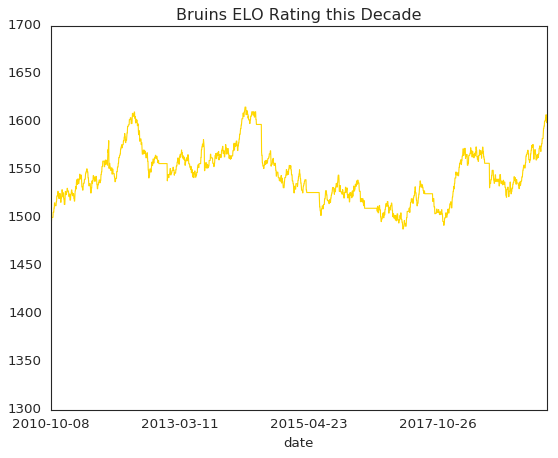

In [0]:

plt.style.use('classic')
sns.set_style('white')

fig = elo_tracker[elo_tracker['team']=='6'].plot(x='date', y='elo_rating', color='gold',
                                                title='Bruins ELO Rating this Decade',
                                                legend=False, ylim=[1300, 1700])

display(fig)

## Getting Teams Days Rest and Time Zone Difference

In [0]:
#Columns required for getting a teams rest days, and venue differential
team_rest = game_df[['game_id', 'season', 'type', 'date_time', 'away_team_id', 'home_team_id', 'venue_time_zone_offset']]

In [0]:
rest_df = pd.DataFrame(columns=['team', 'season', 'game_id', 'date_time', 'venue_time_zone_offset'])

#Because teams can be present in both home and away columns, I am looping through all the teams, seeing if they are in team_rest
#and adding their rest information to rest_df
for i in range(1, 33):
  i = str(i)
  
  cur_team = team_rest[(np.logical_or(team_rest['away_team_id']==i, team_rest['home_team_id']==i))]
  cur_team['team'] = i
  cur_team = cur_team[['team', 'season', 'game_id', 'date_time', 'venue_time_zone_offset']]
  
  rest_df = rest_df.append(cur_team).reset_index(drop=True)
  
rest_df['venue_time_zone_offset'] = rest_df['venue_time_zone_offset'].astype('int')
  

/local_disk0/tmp/1588794251919-0/PythonShell.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 import signal

In [0]:
#Gets the number of days in DatetimeIndex form
dayList = list(pd.DatetimeIndex(rest_df['date_time']) - pd.DatetimeIndex(rest_df['date_time'].shift(1)))

for i in range(1, len(rest_df)):
  #Converts the number of days to a string
  daysOff = str(dayList[i]).split(' ')[0]
  

  rest_df.loc[i, 'daysOff'] = daysOff
  rest_df.loc[i, 'time_zone_dif'] = (rest_df.loc[i, 'venue_time_zone_offset'] - rest_df.loc[i-1, 'venue_time_zone_offset']).astype('int')
    
  try:
    if rest_df.loc[i, 'season'] != rest_df.loc[i-1, 'season']:
      rest_df.loc[i, 'daysOff'] = 5
      
    if rest_df.loc[i, 'team'] != rest_df.loc[i-1, 'team']:
      rest_df.loc[i, 'daysOff'] = 5
      
         
  except: pass

rest_df['daysOff'] = rest_df['daysOff'].fillna(5).astype('int')
rest_df['time_zone_dif'] = rest_df['time_zone_dif'].fillna(0).astype('int')

elo_rest merges the elo dataframe with the rest dataframe.

In [0]:
elo_rest = elo_df.merge(rest_df, left_on=['game_id', 'home_team_id', 'date_time', 'season'], right_on = ['game_id', 'team', 'date_time', 'season'])
elo_rest = elo_rest.rename(columns={'daysOff' : 'home_days_off', 'time_zone_dif' : 'home_time_zone_dif'}).drop(['team', 'venue_time_zone_offset'], axis=1)

elo_rest = elo_rest.merge(rest_df, left_on=['game_id', 'away_team_id', 'date_time', 'season'], right_on = ['game_id', 'team', 'date_time', 'season']).drop(['team', 'venue_time_zone_offset'], axis=1)
elo_rest = elo_rest.rename(columns={'daysOff' : 'away_days_off', 'time_zone_dif' : 'away_time_zone_dif'})

Now that we are done with feature engineering, we bring it back to a pyspark dataframe

In [0]:
#Bring the table with ELO ratings
elo_rest = spark.createDataFrame(elo_rest)
elo_rest = elo_rest.withColumn("playoff", when(elo_rest["type"]=='P',1).otherwise(0))
elo_rest = elo_rest.withColumn("label", when(elo_rest["ScoreDifferential"]>0,1).otherwise(0))

In [0]:
display(elo_rest)

season,date_time,game_id,type,home_team_id,away_team_id,home_goals,away_goals,ScoreDifferential,Home Elo,Away Elo,Elo Change,elo_dif,home_days_off,home_time_zone_dif,away_days_off,away_time_zone_dif,playoff,label
20102011,2010-10-07,2010020003,R,30,12,3,4,-1,1500.0,1500.0,2.756115388880952,0.0,5,-1,5,-1,0,0
20102011,2010-10-07,2010020001,R,10,8,3,2,1,1500.0,1500.0,2.7262117861082835,0.0,5,0,5,0,0,1
20102011,2010-10-07,2010020002,R,5,4,2,3,-1,1500.0,1500.0,2.756115388880952,0.0,5,0,5,0,0,0
20102011,2010-10-08,2010020004,R,21,16,4,3,1,1500.0,1500.0,2.7262117861082835,0.0,5,0,5,-2,0,1
20102011,2010-10-08,2010020005,R,22,20,4,0,4,1500.0,1500.0,6.330067738777879,0.0,5,1,5,-2,0,1
20102011,2010-10-08,2010020008,R,12,30,2,1,1,1502.76,1497.24,2.6762935335759317,5.519999999999982,1,1,1,1,0,1
20102011,2010-10-08,2010020006,R,29,28,2,3,-1,1500.0,1500.0,2.756115388880952,0.0,5,1,5,3,0,0
20102011,2010-10-08,2010020007,R,1,25,3,4,-1,1500.0,1500.0,2.756115388880952,0.0,5,0,5,3,0,0
20102011,2010-10-08,2010020011,R,11,15,4,2,2,1500.0,1500.0,4.320943450005675,0.0,5,0,5,0,0,1
20102011,2010-10-08,2010020010,R,9,7,1,2,-1,1500.0,1500.0,2.756115388880952,0.0,5,0,5,0,0,0


Using Machine Learning to use these features, and predict the results of games

In [0]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = [
  'elo_dif', 'home_days_off', 'away_days_off', 'home_time_zone_dif', 'away_time_zone_dif', 'playoff'], outputCol = 'features')

In [0]:
transformed_elo = vectorAssembler.transform(elo_rest)

In [0]:
train, test = transformed_elo.randomSplit([0.6, 0.4], seed=10)

In [0]:
from pyspark.ml.classification import LogisticRegression
dt = LogisticRegression(labelCol="label",featuresCol="features")


#Train the logistics regression model based on training dataset
dtModel = dt.fit(train)

# Use the model to make prediction
dtPred=dtModel.transform(test)

#Evalaute model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()\
  .setMetricName("areaUnderROC")\
  .setRawPredictionCol("prediction")\
  .setLabelCol("label")

evaluator.evaluate(dtPred)

Out[19]: 0.5518417874396135

In [0]:
print("prediction accuracy is: ", dtPred.where("prediction==label").count()/dtPred.count())

tp=dtPred.where("label=1 and prediction=1").count()
fp=dtPred.where("label=0 and prediction=1").count()
tn=dtPred.where("label=0 and prediction=0").count()
fn=dtPred.where("label=1 and prediction=0").count()

print("true positive is: ", tp)

print("false positive is: ", fp)

print("true negative is: ", tn)

print("false negative is ", fn)

print("precision is ", tp/(tp+fp)) 

print("recall is ", tp/(tp+fn))


prediction accuracy is: 0.5704697986577181
true positive is: 1737
false positive is: 1305
true negative is: 558
false negative is 423
precision is 0.5710059171597633
recall is 0.8041666666666667